# Q4.1: Transfer Learning (VGG16 vs ResNet50) - Frozen vs Fine-Tuned

Use pretrained CNN backbones to classify images, comparing **feature extraction (frozen layers)** vs **fine-tuning**.

**Exam outputs:** accuracy/loss curves and a clear comparison of frozen vs fine-tuned performance.

## Step 1: Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Libraries imported")

Libraries imported


## Step 2: Load and Preprocess CIFAR-10

In [2]:
# Load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Use subset for faster training
X_train = X_train[:5000]
y_train = y_train[:5000]
X_test = X_test[:1000]
y_test = y_test[:1000]

# Normalize
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encode
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Resize to 96x96 (smaller than 224 for speed)
from tensorflow.image import resize
X_train_resized = resize(X_train, (96, 96)).numpy()
X_test_resized = resize(X_test, (96, 96)).numpy()

print(f"Training samples: {X_train_resized.shape[0]}")
print(f"Test samples: {X_test_resized.shape[0]}")
print(f"Image shape: {X_train_resized.shape[1:]}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Training samples: 5000
Test samples: 1000
Image shape: (96, 96, 3)


## Step 3: Build VGG-16 Transfer Learning Model

### Frozen Layers Version

In [3]:
# Load VGG-16 without top layers
base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze all layers
for layer in base_vgg.layers:
    layer.trainable = False

# Add custom classifier
x = base_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

vgg_frozen = Model(inputs=base_vgg.input, outputs=predictions)

print(f"VGG-16 trainable params: {sum([np.prod(p.shape) for p in vgg_frozen.trainable_weights])}")
print(f"VGG-16 total params: {vgg_frozen.count_params()}")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
VGG-16 trainable params: 133898
VGG-16 total params: 14848586


### Train VGG-16 (Frozen)

In [4]:
vgg_frozen.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

print("Training VGG-16 (frozen)...")
history_vgg_frozen = vgg_frozen.fit(X_train_resized, y_train_cat,
                                     batch_size=32,
                                     epochs=10,
                                     validation_split=0.2,
                                     verbose=1)

loss_vgg_frozen, acc_vgg_frozen = vgg_frozen.evaluate(X_test_resized, y_test_cat, verbose=0)
print(f"\nVGG-16 (frozen) Test Accuracy: {acc_vgg_frozen*100:.2f}%")

Training VGG-16 (frozen)...
Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.2207 - loss: 2.1520 - val_accuracy: 0.4840 - val_loss: 1.5932
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.4630 - loss: 1.5596 - val_accuracy: 0.5510 - val_loss: 1.3680
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.5214 - loss: 1.3972 - val_accuracy: 0.5630 - val_loss: 1.2876
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.5471 - loss: 1.2589 - val_accuracy: 0.5750 - val_loss: 1.2268
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.5918 - loss: 1.1804 - val_accuracy: 0.5990 - val_loss: 1.1822
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.6070 - loss: 1.1481 - val_accuracy: 0.5920 - val_loss: 1.1885
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.6168 - loss: 1.1034 - val_accuracy: 0.6190 - val_loss: 1.1205
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.6

## Step 4: Build ResNet-50 Transfer Learning Model

### Frozen Layers Version

In [5]:
# Load ResNet-50 without top layers
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze all layers
for layer in base_resnet.layers:
    layer.trainable = False

# Add custom classifier
x = base_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

resnet_frozen = Model(inputs=base_resnet.input, outputs=predictions)

print(f"ResNet-50 trainable params: {sum([np.prod(p.shape) for p in resnet_frozen.trainable_weights])}")
print(f"ResNet-50 total params: {resnet_frozen.count_params()}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
ResNet-50 trainable params: 527114
ResNet-50 total params: 24114826


### Train ResNet-50 (Frozen)

In [6]:
resnet_frozen.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

print("Training ResNet-50 (frozen)...")
history_resnet_frozen = resnet_frozen.fit(X_train_resized, y_train_cat,
                                           batch_size=32,
                                           epochs=10,
                                           validation_split=0.2,
                                           verbose=1)

loss_resnet_frozen, acc_resnet_frozen = resnet_frozen.evaluate(X_test_resized, y_test_cat, verbose=0)
print(f"\nResNet-50 (frozen) Test Accuracy: {acc_resnet_frozen*100:.2f}%")

Training ResNet-50 (frozen)...
Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.1039 - loss: 2.3846 - val_accuracy: 0.1480 - val_loss: 2.2902
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.1343 - loss: 2.2815 - val_accuracy: 0.1570 - val_loss: 2.2589
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.1423 - loss: 2.2576 - val_accuracy: 0.1870 - val_loss: 2.2250
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.1641 - loss: 2.2394 - val_accuracy: 0.2230 - val_loss: 2.1887
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.1794 - loss: 2.1961 - val_accuracy: 0.2220 - val_loss: 2.1571
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.1949 - loss: 2.1605 - val_accuracy: 0.2040 - val_loss: 2.1412
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.2007 - loss: 2.1352 - val_accuracy: 0.2240 - val_loss: 2.1003
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 

## Step 5: Fine-Tuning - Unfreeze Last Few Layers

### Fine-tune VGG-16

In [7]:
# Unfreeze last 4 layers of VGG-16
for layer in base_vgg.layers[-4:]:
    layer.trainable = True

# Rebuild model
x = base_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

vgg_finetuned = Model(inputs=base_vgg.input, outputs=predictions)

vgg_finetuned.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Lower LR
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

print(f"VGG-16 fine-tuned trainable params: {sum([np.prod(p.shape) for p in vgg_finetuned.trainable_weights])}")

print("\nFine-tuning VGG-16...")
history_vgg_finetuned = vgg_finetuned.fit(X_train_resized, y_train_cat,
                                           batch_size=32,
                                           epochs=10,
                                           validation_split=0.2,
                                           verbose=1)

loss_vgg_ft, acc_vgg_ft = vgg_finetuned.evaluate(X_test_resized, y_test_cat, verbose=0)
print(f"\nVGG-16 (fine-tuned) Test Accuracy: {acc_vgg_ft*100:.2f}%")

VGG-16 fine-tuned trainable params: 7213322

Fine-tuning VGG-16...
Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.2921 - loss: 1.9598 - val_accuracy: 0.6640 - val_loss: 1.0003
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.6599 - loss: 0.9891 - val_accuracy: 0.7240 - val_loss: 0.8207
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.7616 - loss: 0.7363 - val_accuracy: 0.7370 - val_loss: 0.7692
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.8262 - loss: 0.5070 - val_accuracy: 0.7600 - val_loss: 0.6830
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.8826 - loss: 0.3562 - val_accuracy: 0.7720 - val_loss: 0.7088
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.9275 - loss: 0.2350 - val_accuracy: 0.7840 - val_loss: 0.7127
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.9663 - loss: 0.1246 - val_accuracy: 0.7530 - val_loss: 0.8468
Epoch 8/10
125/125 ━━━━━━━━━━

## Step 6: Compare Results

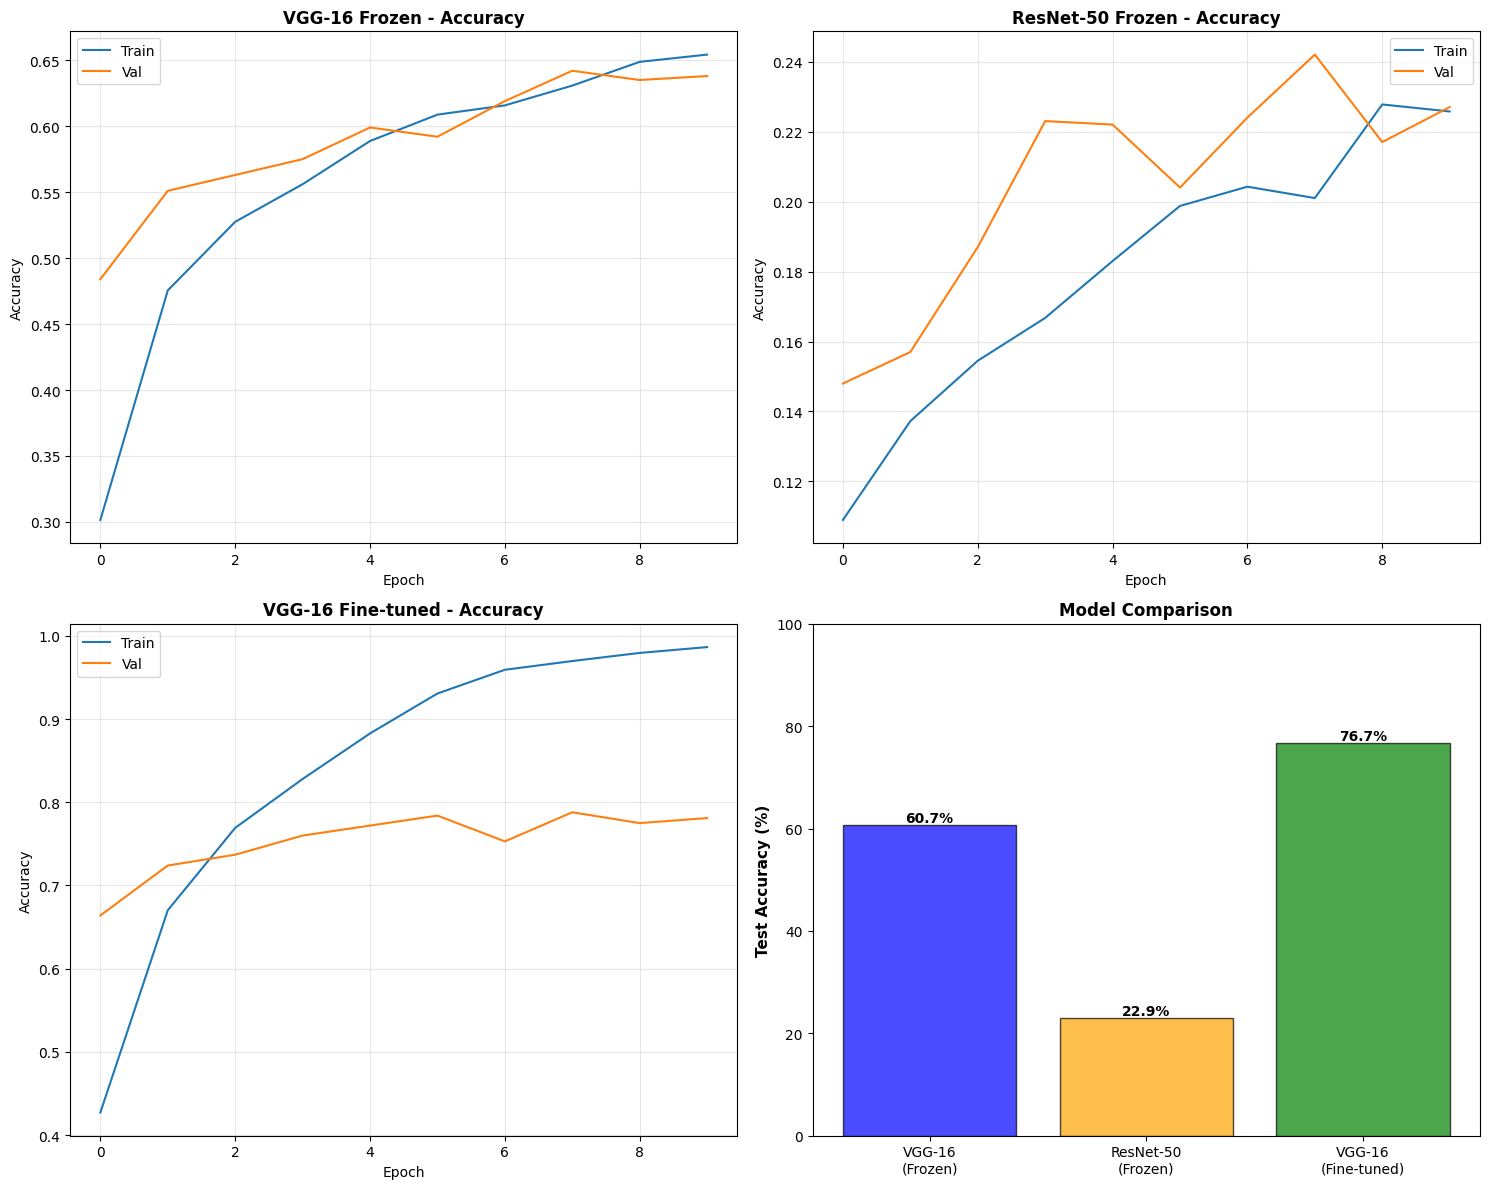

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# VGG frozen
ax1.plot(history_vgg_frozen.history['accuracy'], label='Train')
ax1.plot(history_vgg_frozen.history['val_accuracy'], label='Val')
ax1.set_title('VGG-16 Frozen - Accuracy', fontsize=12, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(alpha=0.3)

# ResNet frozen
ax2.plot(history_resnet_frozen.history['accuracy'], label='Train')
ax2.plot(history_resnet_frozen.history['val_accuracy'], label='Val')
ax2.set_title('ResNet-50 Frozen - Accuracy', fontsize=12, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

# VGG fine-tuned
ax3.plot(history_vgg_finetuned.history['accuracy'], label='Train')
ax3.plot(history_vgg_finetuned.history['val_accuracy'], label='Val')
ax3.set_title('VGG-16 Fine-tuned - Accuracy', fontsize=12, fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()
ax3.grid(alpha=0.3)

# Comparison bar chart
models = ['VGG-16\n(Frozen)', 'ResNet-50\n(Frozen)', 'VGG-16\n(Fine-tuned)']
accuracies = [acc_vgg_frozen*100, acc_resnet_frozen*100, acc_vgg_ft*100]
colors = ['blue', 'orange', 'green']

bars = ax4.bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black')
ax4.set_ylabel('Test Accuracy (%)', fontsize=11, fontweight='bold')
ax4.set_title('Model Comparison', fontsize=12, fontweight='bold')
ax4.set_ylim([0, 100])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Step 7: Summary Table

In [9]:
import pandas as pd

results = pd.DataFrame({
    'Model': ['VGG-16 (Frozen)', 'ResNet-50 (Frozen)', 'VGG-16 (Fine-tuned)'],
    'Test Accuracy': [f"{acc_vgg_frozen*100:.2f}%",
                      f"{acc_resnet_frozen*100:.2f}%",
                      f"{acc_vgg_ft*100:.2f}%"],
    'Trainable Params': [
        sum([np.prod(p.shape) for p in vgg_frozen.trainable_weights]),
        sum([np.prod(p.shape) for p in resnet_frozen.trainable_weights]),
        sum([np.prod(p.shape) for p in vgg_finetuned.trainable_weights])
    ]
})

print("\n=== TRANSFER LEARNING RESULTS ===")
print(results.to_string(index=False))

print("\nObservations:")
print("- Frozen models train faster (fewer parameters)")
print("- Fine-tuning improves accuracy but requires lower learning rate")
print("- Pretrained features effective for similar tasks (ImageNet → CIFAR-10)")


=== TRANSFER LEARNING RESULTS ===
              Model Test Accuracy  Trainable Params
    VGG-16 (Frozen)        60.70%           7213322
 ResNet-50 (Frozen)        22.90%            527114
VGG-16 (Fine-tuned)        76.70%           7213322

Observations:
- Frozen models train faster (fewer parameters)
- Fine-tuning improves accuracy but requires lower learning rate
- Pretrained features effective for similar tasks (ImageNet → CIFAR-10)


## Summary

**Transfer Learning Strategies:**
1. **Feature Extraction (Frozen)**: Use pretrained conv layers as fixed feature extractor
2. **Fine-tuning**: Unfreeze last few layers and train with low learning rate

**Key Techniques:**
- `include_top=False`: Remove original classifier
- `layer.trainable = False`: Freeze weights
- Lower LR for fine-tuning (0.0001 vs 0.001)
- GlobalAveragePooling2D for dimensionality reduction

**When to use:**
- Small dataset
- Similar domain (ImageNet features generalize well)
- Limited compute resources